In [ ]:
import pandas as pd
import random
from scipy.stats import pearsonr



def get_results_and_drug_vis(algorithm, sample, test_mode, normalized):

    t_vs_p_path = None
    if test_mode == "LPO":
        t_vs_p_path = 'to_the_universe_new/true_vs_pred.csv'
    elif test_mode == "LCO":
        t_vs_p_path = 'to_the_stars/true_vs_pred.csv'
    elif test_mode == "LDO":
        t_vs_p_path = 'ldo_results/true_vs_pred.csv'
    else:
        raise ValueError("Invalid test mode")
    results = pd.read_csv(t_vs_p_path, dtype={"drug": str, "cell_line": str, "CV_split": int})
    results = results[results['rand_setting'] =="predictions"]
    results = results[results['algorithm'] ==algorithm]
    # Load drug name mapping
    pubchem_id_to_drugname = pd.read_csv('../data/CTRPv2/drug_names.csv')


    if sample == "picked":
        viz_drugs = ["bafilomycin A1", "chlorambucil", "NSC 74859","hyperforin", "Docetaxel", "C6-ceramide", "obatoclax", "Entinostat", "etomoxir"]
        pubchem_ids = []
        for drug in viz_drugs:
            pubchem_ids.append(pubchem_id_to_drugname[pubchem_id_to_drugname['drug_name'] == drug]['pubchem_id'].values[0])
        viz_drugs = pubchem_ids
    elif sample == "top":
        viz_drugs = results['drug'].value_counts().index[:10]
    elif sample == "random":
        viz_drugs = results['drug'].unique()
        #choose  random drugs
        random.seed(42)
        viz_drugs = random.sample(list(viz_drugs), 12)
    elif sample =="lowest_pearson":

        # Compute Pearson correlation per drug
        pearsons = results.groupby('drug').apply(lambda g: pearsonr(g['y_true'], g['y_pred'])[0])

        # Drop NaNs (in case a drug has constant y_true or y_pred)
        pearsons = pearsons.dropna()

        # Select 10 drugs with lowest Pearson correlation
        viz_drugs = pearsons.nsmallest(50).index.tolist()
    else:
        raise ValueError("Invalid sample option")

    # Filter mapping to only include  viz drugs
    top_drug_names = pubchem_id_to_drugname[pubchem_id_to_drugname['pubchem_id'].isin(viz_drugs)]

    # Create mapping dict
    id_to_name = dict(zip(top_drug_names['pubchem_id'], top_drug_names['drug_name']))
    results['drug'] = results['drug'].astype(str)
    pubchem_id_to_drugname['pubchem_id'] = pubchem_id_to_drugname['pubchem_id'].astype(str)

    # Map drug IDs to names, fill with "Other" if not in 
    results["drug_name_viz"] = results['drug'].map(id_to_name).fillna("Other")
    if not normalized:
        return results
    else:

        # Load and filter
        results2 = pd.read_csv(t_vs_p_path, dtype={"drug": str, "cell_line": str, "CV_split": int}, index_col=0)
        results2 = results2[results2["rand_setting"] == "predictions"]

        # Ensure consistent types
        results2["drug"] = results2["drug"].astype(str)
        results2["cell_line"] = results2["cell_line"].astype(str)
        results2["CV_split"] = results2["CV_split"].astype(int)

        # Prepare naive predictions
        naive = results2[results2["algorithm"] == "NaiveMeanEffectsPredictor"].copy()
        naive["drug"] = naive["drug"].astype(str)
        naive["cell_line"] = naive["cell_line"].astype(str)
        naive["CV_split"] = naive["CV_split"].astype(int)

        naive = naive[["drug", "cell_line", "CV_split", "y_pred"]].rename(columns={"y_pred": "naive_y_pred"})

        # Merge
        merged = results2.merge(naive, on=["drug", "cell_line"], how="left")

        # Drop any rows where naive_y_pred is missing (just in case)
        merged = merged.dropna(subset=["naive_y_pred"])

        # Subtract naive prediction from y_pred and y_true
        merged["y_pred"] = merged["y_pred"] - merged["naive_y_pred"]
        merged["y_true"] = merged["y_true"] - merged["naive_y_pred"]

        merged = merged[merged['algorithm'] ==algorithm]


        # Map drug IDs to names, fill with "Other" if not in 
        merged["drug_name_viz"] = merged['drug'].map(id_to_name).fillna("Other")
        merged.rename(columns={"CV_split_x": "CV_split"})
        return merged
#results_lpo = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=False, normalized=False)
#results_lpo_norm = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=False, normalized=True)
#results_lco = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=True, normalized=False)
#results_lco_norm = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=True, normalized=True)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_variance_decomposition(y_true, y_pred_rf, y_pred_nm):
    tss = np.var(y_true, ddof=0)
    rss_rf = np.mean((y_true - y_pred_rf) ** 2)
    rss_nm = np.mean((y_true - y_pred_nm) ** 2)
    ess_rf = tss - rss_rf
    ess_nm = tss - rss_nm
    extra_ess = ess_rf - ess_nm
    unexplained = tss - ess_rf
    return {
        "naive": ess_nm / tss if tss > 0 else 0,
        "rf_gain": extra_ess / tss if tss > 0 else 0,
        "unexplained": unexplained / tss if tss > 0 else 0,
    }

def compute_splitwise_variance_decomposition(rf_df, nm_df):
    # Handle CV_split_x if present
    if 'CV_split' in rf_df.columns and 'CV_split' in nm_df.columns:
        split_col = 'CV_split'
    elif 'CV_split_x' in rf_df.columns and 'CV_split_x' in nm_df.columns:
        split_col = 'CV_split_x'
    else:
        raise ValueError("Couldn't find a shared CV_split column in input DataFrames.")

    split_ids = sorted(set(rf_df[split_col]) & set(nm_df[split_col]))
    fractions = {"naive": [], "rf_gain": [], "unexplained": []}

    for split in split_ids:
        rf = rf_df[rf_df[split_col] == split].copy()
        nm = nm_df[nm_df[split_col] == split].copy()

        merged = rf.merge(
            nm[['drug', 'cell_line', 'y_pred']],
            on=['drug', 'cell_line'],
            suffixes=('_rf', '_nm')
        )

        y_true = merged['y_true'].values
        y_pred_rf = merged['y_pred_rf'].values
        y_pred_nm = merged['y_pred_nm'].values

        metrics = compute_variance_decomposition(y_true, y_pred_rf, y_pred_nm)
        for k in fractions:
            fractions[k].append(metrics[k])

    return {k: (np.mean(v), np.std(v)) for k, v in fractions.items()}

def plot_stacked_decomposition_with_error(metrics_raw, metrics_norm, filename):
    labels = ['Naive model', 'RF gain', 'Unexplained']
    colors = ['#999999', '#3355aa', '#cc3333']
    components = ['naive', 'rf_gain', 'unexplained']

    def get_means_stds(metrics):
        return [metrics[c][0] for c in components], [metrics[c][1] for c in components]

    raw_means, raw_stds = get_means_stds(metrics_raw)
    norm_means, norm_stds = get_means_stds(metrics_norm)

    fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharey=True)

    def plot_stack(ax, means, stds, title):
        bottom = 0
        for i, (m, s, color, label) in enumerate(zip(means, stds, colors, labels)):
            ax.bar(0, m * 100, bottom=bottom * 100, color=color, edgecolor='black', width=0.6)
            ax.errorbar(
                0, (bottom + m / 2) * 100, yerr=s * 100 / 2,
                ecolor='black', capsize=4, fmt='none', linewidth=1
            )
            bottom += m

        ax.set_xlim(-0.7, 0.7)
        ax.set_ylim(0, 110)
        ax.set_xticks([0])
        ax.set_xticklabels([title])
        ax.tick_params(axis='y', labelsize=9)
        ax.set_ylabel('% of total variance', fontsize=11)

    plot_stack(axes[0], raw_means, raw_stds, 'Raw')
    plot_stack(axes[1], norm_means, norm_stds, 'Normalized')

    axes[1].legend(labels, loc='upper right', frameon=False, fontsize=9)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()



In [ ]:
rf_raw = get_results_and_drug_vis(algorithm="RandomForest", sample=SAMPLE, LCO=True, normalized=False)
nm_raw = get_results_and_drug_vis(algorithm="NaiveMeanEffectsPredictor", sample=SAMPLE, LCO=True, normalized=False)

rf_norm = get_results_and_drug_vis(algorithm="RandomForest", sample=SAMPLE, LCO=True, normalized=True)
nm_norm = get_results_and_drug_vis(algorithm="NaiveMeanEffectsPredictor", sample=SAMPLE, LCO=True, normalized=True)


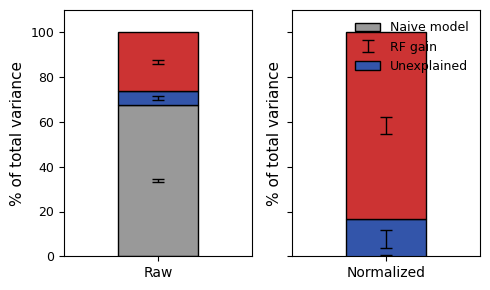

In [20]:

metrics_raw = compute_splitwise_variance_decomposition(rf_raw, nm_raw)
metrics_norm = compute_splitwise_variance_decomposition(rf_norm, nm_norm)

plot_stacked_decomposition_with_error(metrics_raw, metrics_norm, "variance_decomposition_stacked_mean_std.pdf")
